Maximum of col0 is 47 minimum is -1 
Maximum of col1 is 100 minimum is 5 
Maximum of col2 is 53 minimum is 0 
Maximum of col3 is 13.5 minimum is 0.0 
Maximum of col4 is 100 minimum is 0 


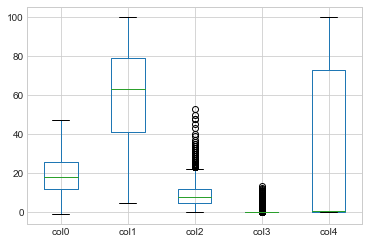

In [2]:

import pandas as pd
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from sklearn import linear_model
plt.style.use('seaborn-whitegrid')
import re
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")


# file inputs 
filename_gen = '/Users/eimearnolan/Google Drive/neurio/data/test_generation.h5'
filename_weather = '/Users/eimearnolan/Google Drive/neurio/data/test_weather.h5'

# extracting h5 files
f_gen = h5py.File(filename_gen, 'r')
f_weather = h5py.File(filename_weather, 'r')
    
# List all keys
#print("Keys generation: %s" % f_gen.keys())
a_group_key_gen = list(f_gen.keys())

#print("/n Keys weather: %s" % f_weather.keys())
a_group_key_weather = list(f_weather.keys())

''' 

    formatting time,location and houses + concatenating all keys from weather 
    and generation files 
    
'''

# reading in and concatenating all generation data with pandas
generation = pd.DataFrame()

for key in list(f_gen.keys()):
     gen_temp = pd.read_hdf(filename_gen,key)
     # creating house and location columns - regex 
     house = re.sub("location[0-4]", "", key)  
     gen_temp['house'] = re.sub("house", "", house)        
     gen_temp['location'] = re.sub("house[0-9]location", "", key)
     # foramtting time columns as python datetime
     gen_temp.time = gen_temp.time.astype(int)
     gen_temp.time = pd.to_datetime(gen_temp['time'],unit='s')
     #gen_temp = gen_temp.set_index('time')


     # concatenating onto full dataset
     generation = pd.concat([generation,gen_temp])
     

# reading in and concatenating all weather data with pandas
# creating location column
weather = pd.DataFrame()

for key in list(f_weather.keys()):
     weather_temp = pd.read_hdf(filename_weather,key)
     weather_temp['location'] = key.replace('location', '')
     # foramtting time columns as python datetime
     weather_temp = weather_temp.reset_index() # adding time as column not index 
     weather_temp.time = weather_temp.time.astype(int)
     weather_temp.time = pd.to_datetime(weather_temp['time'],unit='s')

     # concatenating onto full dataset
     weather = pd.concat([weather,weather_temp])
    
''' 

formatting and exploring columns of weather dataset

'''
    
# investigating column meanings 


# see ranges of columns
boxplot = weather.boxplot(column=['col0','col1', 'col2', 'col3', 'col4'])
print("Maximum of col0 is {0} minimum is {1} ".format(weather.col0.max(), weather.col0.min()))
print("Maximum of col1 is {0} minimum is {1} ".format(weather.col1.max(), weather.col1.min()))
print("Maximum of col2 is {0} minimum is {1} ".format(weather.col2.max(), weather.col2.min()))
print("Maximum of col3 is {0} minimum is {1} ".format(weather.col3.max(), weather.col3.min()))
print("Maximum of col4 is {0} minimum is {1} ".format(weather.col4.max(), weather.col4.min()))


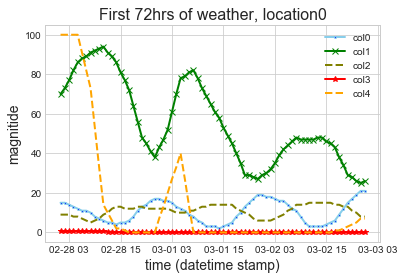

In [3]:
# taking only 36 hrs of data and location 0 to start 
# turn into function with input hrs of samples and location and columns to plot 
weather_sample = weather.loc[weather['location'] == '0']  

# plot against time 
# multiple line plot
plt.plot( 'time', 'col0', data=weather_sample.head(72), marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=2)
plt.plot( 'time', 'col1', data=weather_sample.head(72), marker='x', color='green', linewidth=2)
plt.plot( 'time', 'col2', data=weather_sample.head(72), marker='', color='olive', linewidth=2, linestyle='dashed')
plt.plot( 'time', 'col3', data=weather_sample.head(72), marker='*', color='red', linewidth=2)
plt.plot( 'time', 'col4', data=weather_sample.head(72), marker='', color='orange', linewidth=2, linestyle='dashed')
plt.title('First 72hrs of weather, location0', fontsize=16)
plt.xlabel('time (datetime stamp)', fontsize=14)
plt.ylabel('magnitide', fontsize=14)
plt.legend()

col0 : temperature (C) : range(-1-47) , has sub zero values and is indirectly proportional to wind speed
col1 : % cloud cover : range(5-100) , last remaining column to be named
col2 : wind speed (km/h) : range(0-53) , is indirectly proportional to temperature (wind chill?)
col3 : precipitation (mm) : range(0-13.5) , only variables on the same scale as precipitation mm 
col4 : % humidity : range(0-100) , fluctuates more than col2, suggests humidity as its influenced by cloud cover, temp, time


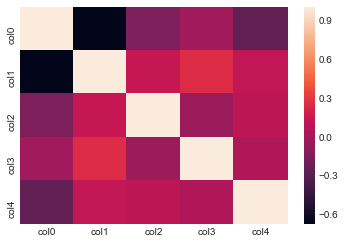

In [4]:
# correlation matrix
corr = weather_sample.corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Final Arguements:

print('col0 : temperature (C) : range(-1-47) , has sub zero values and is indirectly proportional to wind speed')     
print('col1 : % cloud cover : range(5-100) , last remaining column to be named')    
print('col2 : wind speed (km/h) : range(0-53) , is indirectly proportional to temperature (wind chill?)')     
print('col3 : precipitation (mm) : range(0-13.5) , only variables on the same scale as precipitation mm ')    
print('col4 : % humidity : range(0-100) , fluctuates more than col2, suggests humidity as its influenced by cloud cover, temp, time')       

#Report for average values for temp/precipitation/wind_speed/cloud cover/humidity link
#https://www.theweathernetwork.com/forecasts/statistics/precipitation/cl6158350/caon11484 


# renaming weather data 
weather = weather.rename(columns={'col0': 'temperature', 'col1': 'cloudcover', 'col2': 'windspeed', 'col3': 'precipitation', 'col4': 'humidity'})



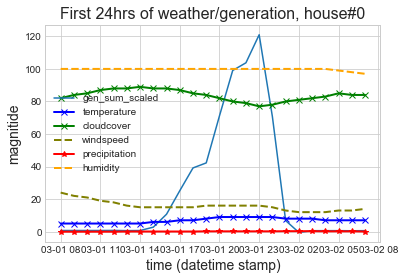

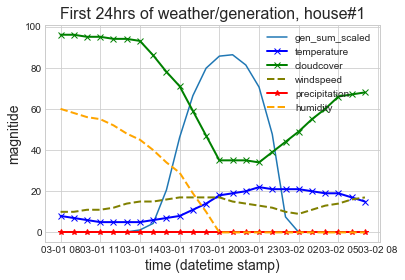

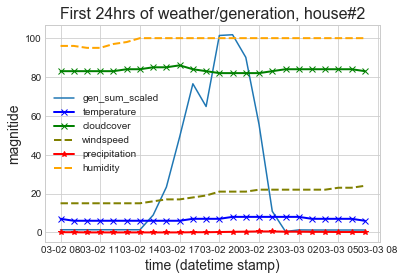

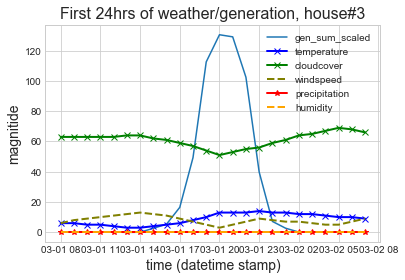

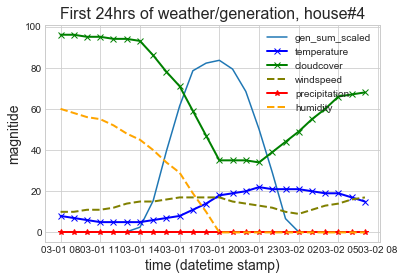

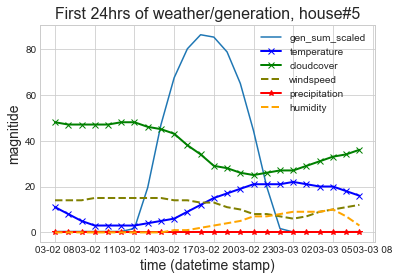

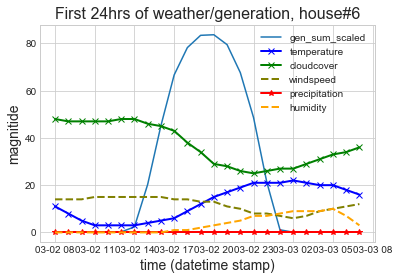

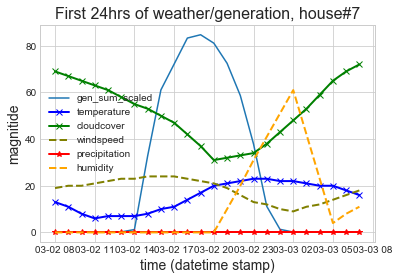

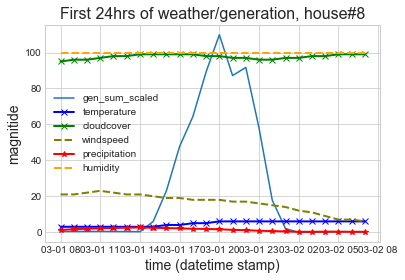

In [5]:
# looking at Generation
#aggregating generation to per hour basis
generation_agg = generation.groupby([generation['time'].dt.floor('H'),'location','house']).agg(['sum'])
generation_agg = generation_agg.reset_index()
generation_agg.columns = ['time', 'location', 'house', 'gen_sum']

# merge generation and weather 
weather_generation = pd.merge(generation_agg, weather, how='inner', left_on = ['time', 'location'], right_on = ['time', 'location'] )

# plot 24 hrs of data for each house 
for house_num in range(weather_generation.house.nunique()):
    
    house = weather_generation.loc[weather_generation['house'] == str(house_num)]
    
    # NB : scaling generation data to see everything better
    house_firstday = house.head(24)
    house_firstday['gen_sum_scaled'] = (house_firstday['gen_sum']/np.mean(house_firstday['gen_sum']))*25

    plt.figure()
    plt.plot( 'time', 'gen_sum_scaled', data=house_firstday)
    plt.plot( 'time', 'temperature', data=house_firstday, marker='x', color='blue', linewidth=2)
    plt.plot( 'time', 'cloudcover', data=house_firstday, marker='x', color='green', linewidth=2)
    plt.plot( 'time', 'windspeed', data=house_firstday, marker='', color='olive', linewidth=2, linestyle='dashed')
    plt.plot( 'time', 'precipitation', data=house_firstday, marker='*', color='red', linewidth=2)
    plt.plot( 'time', 'humidity', data=house_firstday, marker='', color='orange', linewidth=2, linestyle='dashed')
    plt.title('First 24hrs of weather/generation, house#' + str(house_num), fontsize=16)
    plt.xlabel('time (datetime stamp)', fontsize=14)
    plt.ylabel('magnitide', fontsize=14)
    plt.legend()


In [7]:
''' 

    Univariate feature selection : weather feature
    from solar models literature: https://arxiv.org/pdf/1708.08376.pdf 
    # options cloud cover, humidity, temperature
    
    from statistical measures:
        R-squared value, lasso coeff, p-values, selectkfeatures (F-statistic)
                
'''

# splitting into target and dependent variables 
# selecting feature based on f statistic
gen_sum_target= weather_generation.gen_sum
weather_generation_dep = weather_generation.drop(['time','location', 'gen_sum', 'house'], axis=1)
Best_dependent = SelectKBest(feature_selection.f_regression, k=1).fit_transform(weather_generation_dep, gen_sum_target)

# Compare with F-score, p-value
# correlation between each regressor and the target is computed
F, pval = feature_selection.f_regression(weather_generation_dep, gen_sum_target, center = True)

# table of f statistic and p val 
from tabulate import tabulate
print('F-statistic')
print(tabulate([F, pval], headers=['Temp', 'Cloudcover','Windspeed','Precipitation','Humidity']))
print('\n\n P-Values')
print(tabulate([pval], headers=['Temp', 'Cloudcover','Windspeed','Precipitation','Humidity']))



F-statistic
   Temp    Cloudcover       Windspeed    Precipitation         Humidity
-------  ------------  --------------  ---------------  ---------------
7263.45       12378.4  702.649           367.62         1364.61
   0              0      2.16285e-153      1.53681e-81     2.27219e-293


 P-Values
  Temp    Cloudcover     Windspeed    Precipitation      Humidity
------  ------------  ------------  ---------------  ------------
     0             0  2.16285e-153      1.53681e-81  2.27219e-293


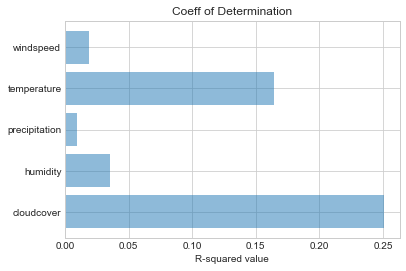

In [13]:
# Coefficient of Determination (R-squared value)
scores = []

for col in weather_generation_dep.columns.values:
    lm = LinearRegression(fit_intercept=True)
    lm.fit(weather_generation_dep[[col]], gen_sum_target)
    score_col= lm.score(weather_generation_dep[[col]], gen_sum_target)
    scores.append(score_col)

coeff_names_w = weather_generation_dep.columns.values
y_pos = np.arange(len(coeff_names_w))

plt.barh(coeff_names_w, scores,  alpha=0.5)
plt.xlabel('R-squared value')
plt.title('Coeff of Determination')
plt.show()


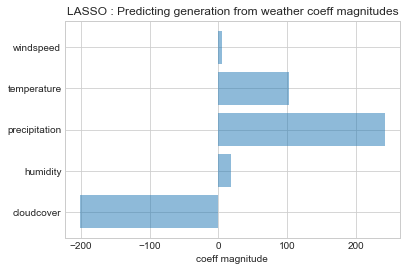

In [14]:
# Lasso Regression 
# Looking at magnitude of coefficients as a measure of predictive power
clf = linear_model.Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=True, positive=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

clf.fit(weather_generation_dep, gen_sum_target)

# plotting coefficient magnitudes
coeff_names = weather_generation_dep.columns.values
y_pos = np.arange(len(coeff_names))

plt.barh(coeff_names, clf.coef_, align='center', alpha=0.5)
plt.xlabel('coeff magnitude')
plt.title('LASSO : Predicting generation from weather coeff magnitudes')
 
plt.show()

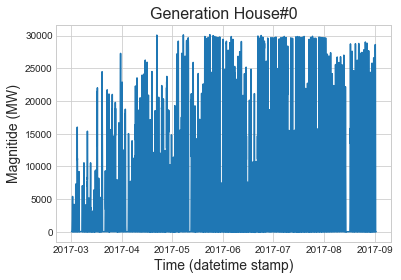

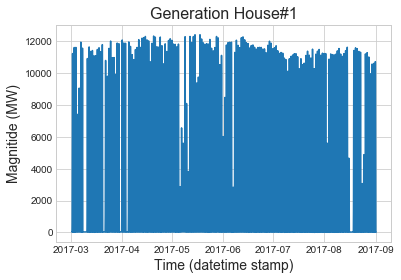

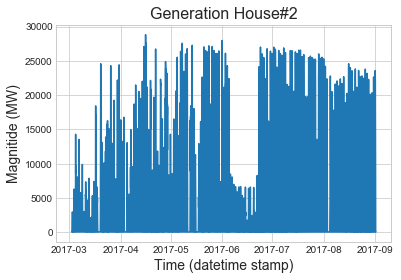

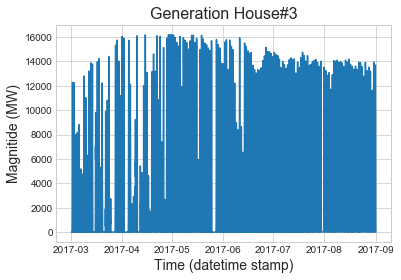

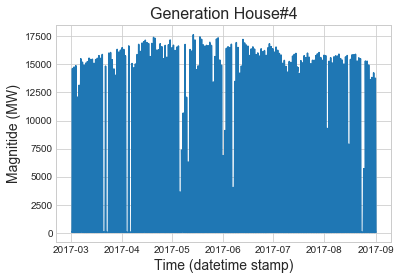

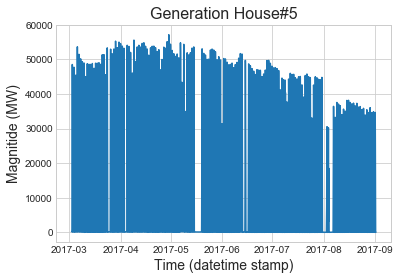

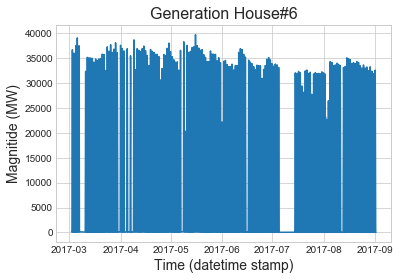

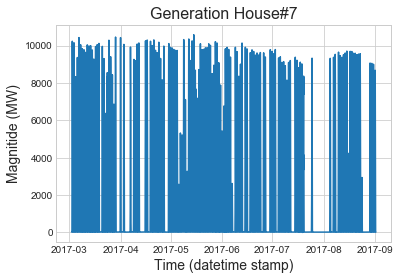

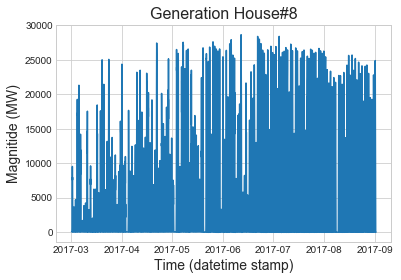

In [15]:
''' 
   Preparing model data
   Dropping houses that aren't preforming (R-squared and generation values)
   Checking if time series is stationary
        
'''
# keeping only cloud cover 
gen_sum_target_model= weather_generation[['time','house', 'gen_sum']]
cloud_cover = weather_generation[['time','house', 'cloudcover']]

# Coefficient of Determination (R-squared value for house correlations)
scores_houses = []
mean_gen_houses = []

fig = plt.figure()

for house_num in range(cloud_cover.house.nunique()):
    lm = LinearRegression(fit_intercept=True)    
    
    house = weather_generation.loc[cloud_cover['house'] == str(house_num)]    
    generation = gen_sum_target_model.loc[gen_sum_target_model['house'] == str(house_num)]    
    
    # data quality - missing values?

    lm.fit(house[['cloudcover']], generation[['gen_sum']])
    scores_house= lm.score(house[['cloudcover']], generation[['gen_sum']])
    scores_houses.append(scores_house)
    mean_gen_houses.append(np.mean(house[['gen_sum']]))

    
    plt.figure()
    plt.plot( generation.time, generation.gen_sum)
    plt.title('Generation House#'+str(house_num), fontsize=16)
    plt.xlabel('Time (datetime stamp)', fontsize=14)
    plt.ylabel('Magnitide (MW)', fontsize=14)
    

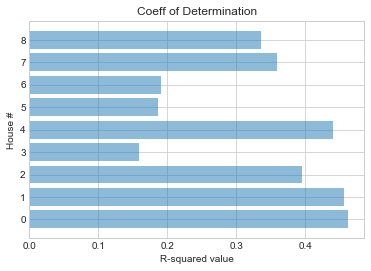


 Dropping houses 3,5,6,7 for either have messy data or low R squared value


In [131]:

house_names = range(cloud_cover.house.nunique())
house_pos = np.arange(len(house_names))

plt.barh(house_names, scores_houses,  alpha=0.5)
plt.yticks(house_pos, house_names)
plt.ylabel('House #')
plt.xlabel('R-squared value')
plt.title('Coeff of Determination')
plt.show()


# Result is drop house number 3,5,6,7
# low correlation with cloud cover and low generation compared to other houses
house_to_keep = ['0','1','2','4','8']
gen_sum_target= weather_generation.loc[weather_generation['house'].isin(house_to_keep)] 
cloud_cover = weather_generation.loc[weather_generation['house'].isin(house_to_keep)]

print('\n Dropping houses 3,5,6,7 for either have messy data or low R squared value')



Training linear regression model for house #0...


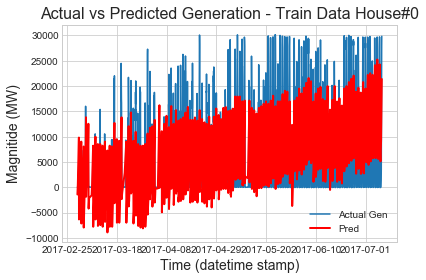

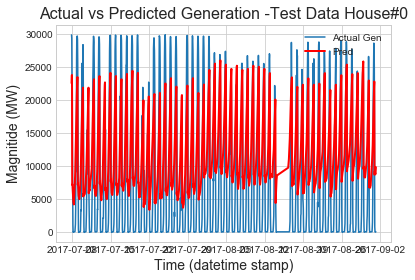

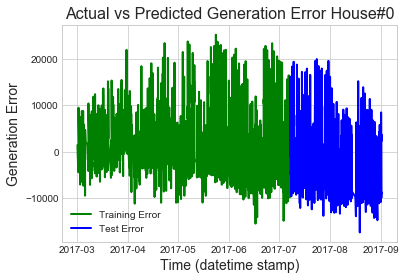

Training linear regression model for house #1...


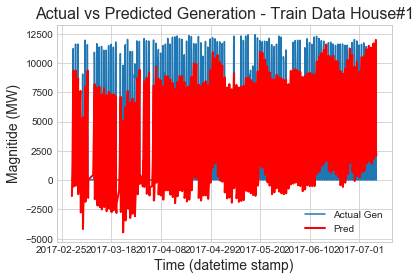

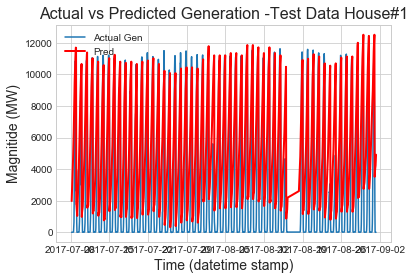

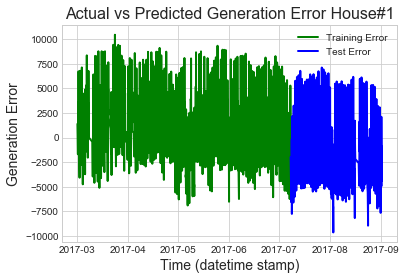

Training linear regression model for house #2...


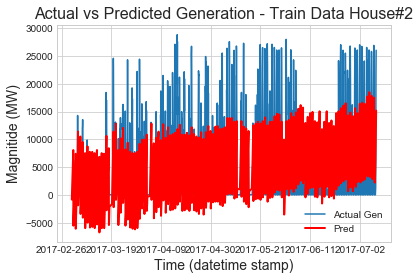

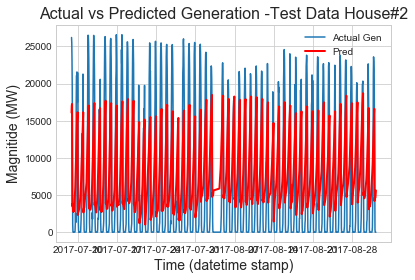

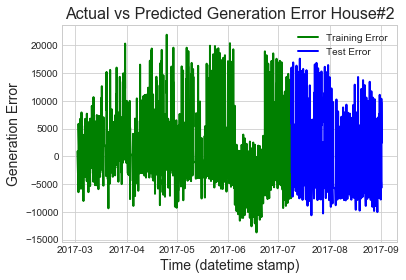

Training linear regression model for house #3...


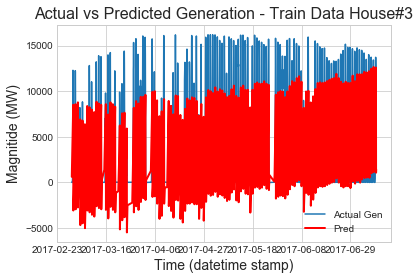

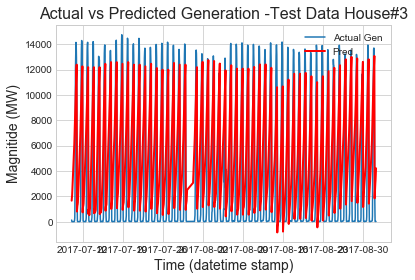

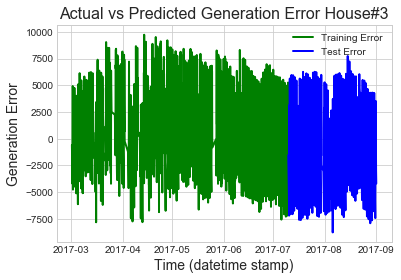

Training linear regression model for house #4...


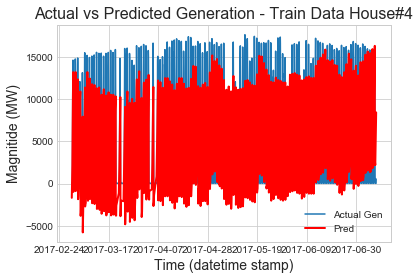

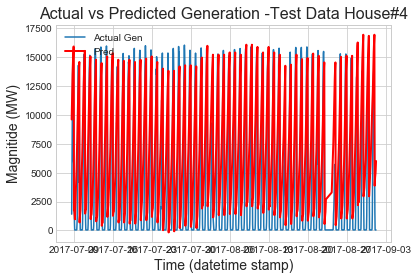

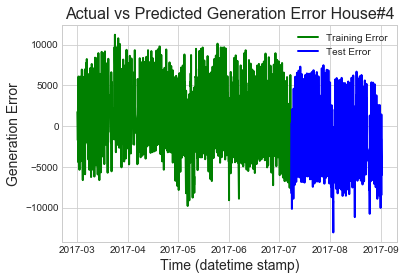

Training linear regression model for house #5...


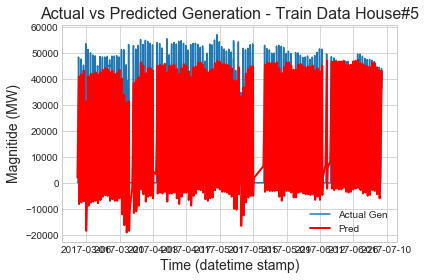

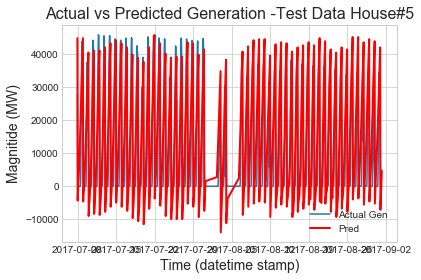

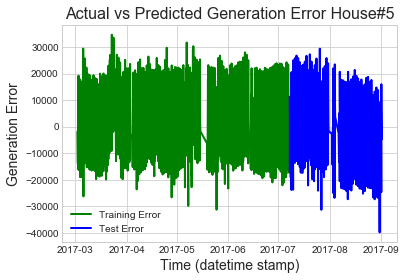

Training linear regression model for house #6...


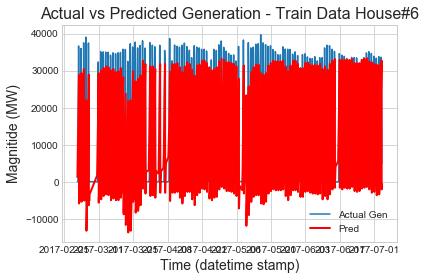

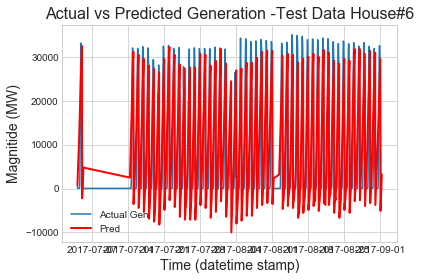

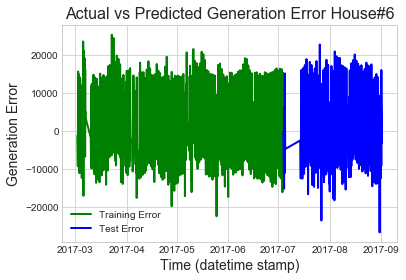

Training linear regression model for house #7...


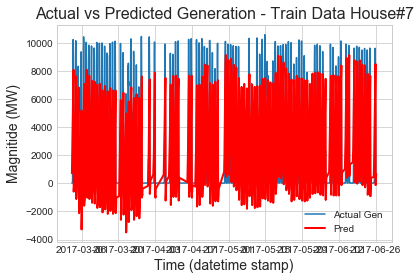

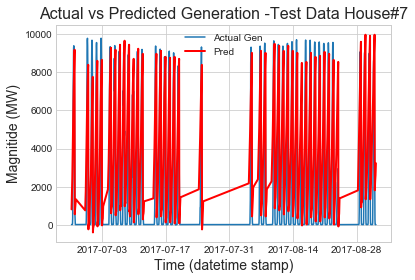

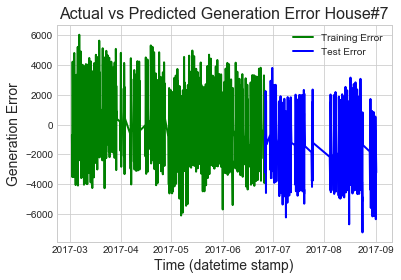

Training linear regression model for house #8...


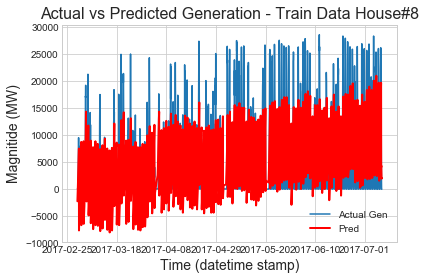

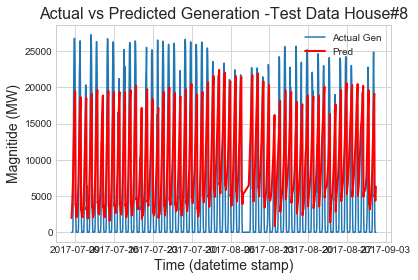

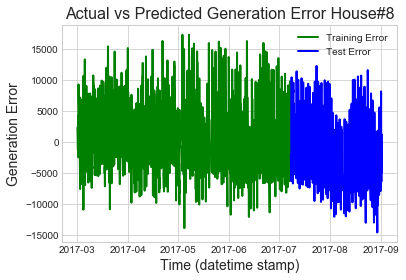

In [33]:

''' 
   Creating model 
   Model choices: VAR, glm?  --> linear regression model on hour, month, cloudcover
   Splitting train, test sets 
   https://arxiv.org/pdf/1708.08376.pdf
   :( no historical generation data given
   
   Could split models by month as well as house?
        
'''

# training function, house number and time 
rms_train = []
rms_test = []

for house in house_to_keep:
    print('Training linear regression model for house #'+str(house)+ '...' )

    wtest = weather_generation.loc[weather_generation['house'] == house]
    data= wtest[['time', 'gen_sum', 'cloudcover']]

    data["hour"] = data["time"].dt.hour # to capture day and night 
    data["month"] = data["time"].dt.month  # to capture seasonality

    #creating the train and validation set, split on past and future data
    # in future use timeseriessplit()
    train_size = int(len(data) * 0.7)
    train, test = data[0:train_size], data[train_size:len(data)]

    #train = target[:int(0.7*(len(target)))]
    #test = target[int(0.3*(len(target))):]

    # Define the model by explicitely saying that our data contains an intercept term
    reg = LinearRegression(fit_intercept=False)

    # Fit the data
    reg.fit(train[['cloudcover','hour', 'month']], train['gen_sum'])

    # Evaluate the model on the given for training
    y_pred_train = reg.predict(train[['cloudcover','hour', 'month']])

    # Evaluate the model on the givenfor training
    y_pred_test= reg.predict(test[['cloudcover','hour', 'month']])

    # Plot comparison test data
    plt.figure()
    plt.plot( 'time', 'gen_sum', data=train)
    plt.plot( train.time, y_pred_train, color='red', linewidth=2)
    plt.title('Actual vs Predicted Generation - Train Data House#'+str(house), fontsize=16)
    plt.xlabel('Time (datetime stamp)', fontsize=14)
    plt.ylabel('Magnitide (MW)', fontsize=14)
    plt.legend(['Actual Gen', 'Pred'])


    # Plot comparison test data
    plt.figure()
    plt.plot( 'time', 'gen_sum', data=test)
    plt.plot( test.time, y_pred_test, color='red', linewidth=2)
    plt.title('Actual vs Predicted Generation -Test Data House#'+str(house), fontsize=16)
    plt.xlabel('Time (datetime stamp)', fontsize=14)
    plt.ylabel('Magnitide (MW)', fontsize=14)
    plt.legend(['Actual Gen', 'Pred'])
    plt.show()

    # training/test error
    plt.figure()
    error_train = train.gen_sum - y_pred_train
    error_test = test.gen_sum - y_pred_test
    plt.figure()
    plt.plot(train.time, error_train, color='green', linewidth=2)
    plt.plot(test.time, error_test, color='blue', linewidth=2)
    plt.title('Actual vs Predicted Generation Error House#'+str(house), fontsize=16)
    plt.xlabel('Time (datetime stamp)', fontsize=14)
    plt.ylabel('Generation Error', fontsize=14)
    plt.legend(['Training Error', 'Test Error'])
    plt.show()


    # root mean sqaured error
    rms_train.append(sqrt(mean_squared_error(train.gen_sum , y_pred_train)))
    rms_test.append(sqrt(mean_squared_error(test.gen_sum , y_pred_test))) 


    


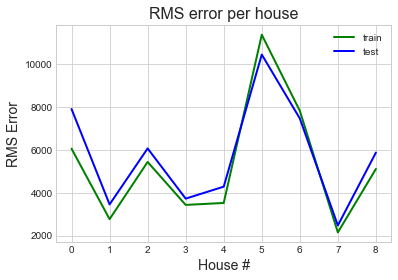

In [31]:
    # rms across houses
    plt.figure()
    plt.plot(house_to_keep, rms_train, color='green', linewidth=2)
    plt.plot(house_to_keep, rms_test, color='blue', linewidth=2)
    plt.title('RMS error per house', fontsize=16)
    plt.xlabel('House #', fontsize=14)
    plt.ylabel('RMS Error', fontsize=14)
    plt.legend( ['train', 'test'])
    plt.show()

In [24]:
''' 

creating functions for models
test data 
        
'''

# calling functions
from train_generation_model import train_generation_model
from predict_generation import predict_generation
from evaluate_model import evaluate_model


# generation data 
weather_generation = pd.read_pickle('weather_generation_data.pkl')

# testing model generation function ...
house_to_keep = ['0','1','2','3', '4','5', '6', '7','8']

# trains linear models for all remaining houses
#train_generation_model(weather_generation, house_to_keep)

# small test on function
timestamp =weather_generation.time[10]  # has to be datetime format !!!
house = 1
timestamp = pd.to_datetime(timestamp, errors='coerce')

# this assumes a function weather!! has dummy variables now ...
pred = predict_generation(timestamp, house)


# dummy test value
actual = 1300
error = evaluate_model(actual,pred)


Predicting generation for house #1


AttributeError: 'Timestamp' object has no attribute 'dt'